In [1]:
#!/usr/bin/env python
# coding: utf-8
# (c) Charles Le Losq, Clément Ferraina 2023
# see embedded licence file
# iVisc 1.0
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
#
# Library Loading
#
import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import numpy as np
np.random.seed = 167 # fix random seed for reproducibility

import time, os

# local imports
import src.utils as utils
import src.ivisc as ivisc

# deep learning libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

import tensorflow as tf
import torch

# import sklearn utils
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler

#from tqdm import tqdm

import gpflow

import joblib


/var/folders/23/p99d2kmd0vlg5qrqb4vq2q840000gn/T/ipykernel_21288/4140654015.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # manipulate dataframes
2024-03-13 20:51:07.312225: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading and models

In [2]:
# Data loading
print("Loading the viscosity datasets...")
ds = utils.data_loader(path_viscosity='./data/all_viscosity.hdf5')

# Add scalers
ds.scaler_tpx = StandardScaler().fit(ds.TPX_train_valid) # for the blackbox model
ds.scaler_px = StandardScaler().fit(ds.PX_train) # for the greybox model

print("Loading the models...")
#Linear Regression
clf_linreg = joblib.load('./models/clf_linreg.joblib')

# Support Vector Machine regression
clf_svr = joblib.load('./models/clf_svr.joblib')

# Artificial Neural Network
clf_nn = joblib.load('./models/clf_nn.joblib')

# Random Forest Regressor
clf_rf = joblib.load('./models/clf_rf.joblib')

# Greybox Neural Network
model_1 = tf.keras.models.load_model('./models/model1_best.keras', 
                                     custom_objects={'MyegaCalculationLayer_model1': ivisc.MyegaCalculationLayer_model1})

# Gaussian Process
gp_model = tf.saved_model.load("./models/GP_Mater32_poly")

models_list = [clf_linreg, clf_svr, clf_rf, clf_nn, model_1, gp_model]
print('Loaded.')

Loading the viscosity datasets...
Loading the models...
Loaded.


In [3]:
def predict_one_compo(di_, # subset
                      ds, # data object
                      models, # list of the models
                      T_interest,
                      P_interest):

    # check composition
    di_ = utils.chimie_control(di_).copy()
    
    # add descriptors
    xi_ = utils.descriptors(di_.loc[:, utils.list_oxides()]).values

    # same composition so we get first line, then create an array with interesting temps
    xi = np.ones((len(T_interest),xi_.shape[1]))*xi_[0,:]

    # transformation
    ptxi_scaled = ds.scale_for_blackbox(T_interest.reshape(-1,1), 
                                        P_interest.reshape(-1,1),xi, ds.scaler_tpx)

    pxi_scaled = ds.scale_for_greybox(P_interest.reshape(-1,1),xi, ds.scaler_px)
    
    tpx_for_gp = ds.scale_for_gaussianprocess(T_interest.reshape(-1,1), 
                                        P_interest.reshape(-1,1),xi)
    

    # predictions 
    oneC_lin = models[0].predict(ptxi_scaled)
    oneC_svr = models[1].predict(ptxi_scaled)
    oneC_nn = models[2].predict(ptxi_scaled)
    oneC_rf = models[3].predict(ptxi_scaled)
    oneC_grey = models[4].predict((pxi_scaled, T_interest.reshape(-1,1)))
    oneC_gp = models[5].compiled_predict_y(tpx_for_gp)
    predictions = (oneC_lin,oneC_svr,oneC_nn,oneC_rf,oneC_grey,oneC_gp)
    return predictions

dataset_peridotite = ds.dataset_hp.loc[ds.dataset_hp.Compo_interest=="peridotite",:].reset_index()
dataset_casio3 = ds.dataset_hp.loc[ds.dataset_hp.Compo_interest=="casio3",:].reset_index()
dataset_mgsio3 = ds.dataset_hp.loc[ds.dataset_hp.Compo_interest=="mgsio3",:].reset_index()
dataset_albite = ds.dataset_hp.loc[ds.dataset_hp.Compo_interest=="albite",:].reset_index()


In [4]:
predictions_albite = predict_one_compo(dataset_albite, ds, models_list, dataset_albite["T"].values, dataset_albite["P"].values)
predictions_casio3 = predict_one_compo(dataset_casio3, ds, models_list, dataset_casio3["T"].values, dataset_casio3["P"].values)
predictions_mgsio3 = predict_one_compo(dataset_mgsio3, ds, models_list, dataset_mgsio3["T"].values, dataset_mgsio3["P"].values)
predictions_peridotite = predict_one_compo(dataset_peridotite, ds, models_list, dataset_peridotite["T"].values, dataset_peridotite["P"].values)

1/1 [==============================] - 0s 21ms/step


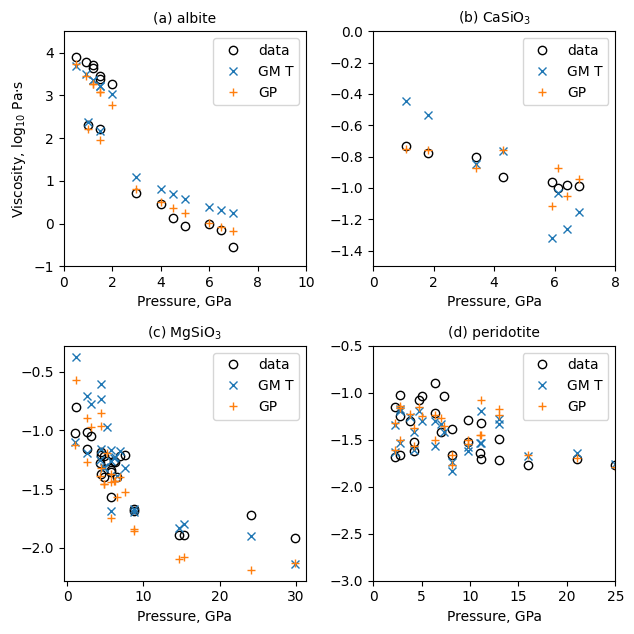

In [5]:
plt.figure(figsize=(6.44,6.44))
plt.subplot(2,2,1)
plt.title("(a) albite", fontsize=10)
plt.plot(dataset_albite.loc[:,"P"],dataset_albite.viscosity, "ko", 
         markerfacecolor="None",label="data")
plt.plot(dataset_albite.loc[:,"P"],
         predictions_albite[4],"x", alpha=1., linestyle="", label="GM T")
plt.plot(dataset_albite.loc[:,"P"],
         predictions_albite[5][0],"+", alpha=1., linestyle="", label="GP")
plt.xlabel("Pressure, GPa")
plt.ylabel("Viscosity, log$_{10}$ Pa$\cdot$s")
plt.ylim(-1,4.5)
plt.xlim(0,10)
plt.legend()

plt.subplot(2,2,2)
plt.title("(b) CaSiO$_3$", fontsize=10)
plt.plot(dataset_casio3.loc[:,"P"],dataset_casio3.viscosity, "ko", 
         markerfacecolor="None",label="data")
plt.plot(dataset_casio3.loc[:,"P"],
         predictions_casio3[4],"x", alpha=1., linestyle="", label="GM T")
plt.plot(dataset_casio3.loc[:,"P"],
         predictions_casio3[5][0],"+", alpha=1., linestyle="", label="GP")
plt.xlabel("Pressure, GPa")
plt.ylim(-1.5,0)
plt.xlim(0,8)
plt.legend()

plt.subplot(2,2,3)
plt.title("(c) MgSiO$_3$", fontsize=10)
plt.plot(dataset_mgsio3.loc[:,"P"],dataset_mgsio3.viscosity, "ko", 
         markerfacecolor="None",label="data")
plt.plot(dataset_mgsio3.loc[:,"P"],
         predictions_mgsio3[4],"x", alpha=1., linestyle="", label="GM T")
plt.plot(dataset_mgsio3.loc[:,"P"],
         predictions_mgsio3[5][0],"+", alpha=1., linestyle="", label="GP")
plt.xlabel("Pressure, GPa")
plt.legend()

plt.subplot(2,2,4)
plt.title("(d) peridotite", fontsize=10)
plt.plot(dataset_peridotite.loc[:,"P"],dataset_peridotite.viscosity, "ko", 
         markerfacecolor="None",label="data")
plt.plot(dataset_peridotite.loc[:,"P"],
         predictions_peridotite[4],"x", alpha=1., linestyle="", label="GM T")
plt.plot(dataset_peridotite.loc[:,"P"],
         predictions_peridotite[5][0],"+", alpha=1., linestyle="", label="GP")
plt.xlabel("Pressure, GPa")
plt.ylim(-3.0,-0.5)
plt.xlim(0,25)
plt.legend()

plt.tight_layout()

## Error comparison

35/35 [==============================] - 0s 2ms/step
RMSE on the entire high pressure dataset are:
for the greybox model: 0.42
for the Gaussian process model: 0.30


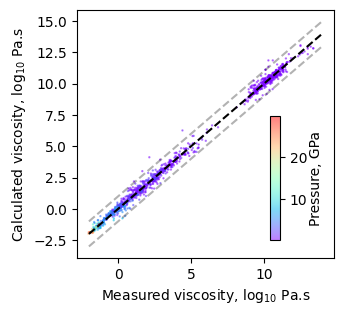

In [6]:
# reading the Pandas dataframe
dataset_hp_ = utils.chimie_control(ds.dataset_hp.sort_values(by="P").copy())
X_hp = utils.descriptors(dataset_hp_.loc[:,utils.list_oxides()])

oneC_greyhp = model_1.predict((ds.scale_for_greybox(dataset_hp_.loc[:,"P"].values, X_hp, ds.scaler_px), 
                              dataset_hp_["T"].values.reshape(-1,1)))
oneC_gp, oneC_gp_var = gp_model.compiled_predict_y(ds.scale_for_gaussianprocess(dataset_hp_["T"].values, 
                              dataset_hp_["P"].values,
                              X_hp.values[:,0:12]))
oneC_gp_std = np.sqrt(oneC_gp_var)

fig = plt.figure(figsize=(3.32,3.22))
ax = plt.subplot()
plt.plot([-2,14],[-2,14],'k--')
plt.plot([-2,14],[-3,13],'k--',alpha=0.3)
plt.plot([-2,14],[-1,15],'k--',alpha=0.3)
pcm = plt.scatter(dataset_hp_.loc[:,'viscosity'].values.reshape(-1,1),
            oneC_gp,
            cmap='rainbow',
            c=dataset_hp_.loc[:,"P"].values.reshape(-1,1),
            marker='.',
            s=2,
            alpha = 0.5
           )
plt.xlabel('Measured viscosity, log$_{10}$ Pa.s')
plt.ylabel('Calculated viscosity, log$_{10}$ Pa.s')
# manual placing of the colorbar
cax = ax.inset_axes([0.75, 0.07, 0.04, 0.5])
cbar = fig.colorbar(pcm,
             cax=cax, orientation='vertical',
             ticks=[0,10,20,30])
cbar.set_label('Pressure, GPa', labelpad=1)

#plt.colorbar(label='Pressure, GPa', anchor=(0.1,0.1))
#plt.tight_layout()
plt.savefig("./figures/pred_vs_meas_HP.pdf")

print("RMSE on the entire high pressure dataset are:")
print("for the greybox model: {:.2f}".format(np.sqrt(mean_squared_error(dataset_hp_.loc[:,'viscosity'].values, oneC_greyhp))))
print("for the Gaussian process model: {:.2f}".format(np.sqrt(mean_squared_error(dataset_hp_.loc[:,'viscosity'].values, oneC_gp))))

# Final figure for paper

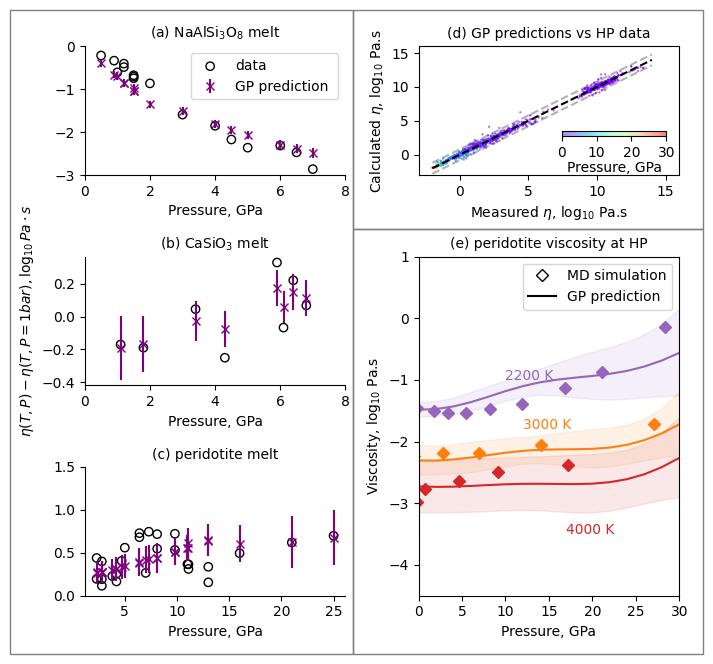

In [7]:
fig = plt.figure(figsize=(7.0,6.44))
ax_hpcomp = plt.subplot(3,2,2)
plt.title("(d) GP predictions vs HP data", fontsize=10)
plt.plot([-2,14],[-2,14],'k--',label="1:1")
plt.plot([-2,14],[-2.8,13.2],'k--',alpha=0.3)
plt.plot([-2,14],[-1.2,14.8],'k--',alpha=0.3)
pcm=plt.scatter(dataset_hp_.loc[:,'viscosity'].values.reshape(-1,1),
            oneC_gp,
            cmap='rainbow',
            c=dataset_hp_.loc[:,"P"].values.reshape(-1,1),
            marker='.',
            s=2,
            alpha = 0.5
           )
plt.xlabel('Measured $\eta$, log$_{10}$ Pa.s')
plt.ylabel('Calculated $\eta$, log$_{10}$ Pa.s')
cax = ax_hpcomp.inset_axes([0.55, 0.3, 0.4, 0.04])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal')
cbar.set_label('Pressure, GPa', labelpad=0.5)
cbar.set_ticks([0,10,20,30], labels=['0','10','20','30'])
plt.xlim(-3,16)
plt.ylim(-3,16)

ax_ab = plt.subplot(3,2,1)
plt.title("(a) NaAlSi$_3$O$_8$ melt", fontsize=10)
plt.scatter(dataset_albite.loc[:,"P"],
            dataset_albite.viscosity - (-4.5+10601/(dataset_albite.loc[:,"T"]-443.7)),  # TVF on LL2013 data
            marker='o',
            facecolor="None",
            edgecolor="k",
            label="data")
plt.errorbar(dataset_albite.loc[:,"P"],
             predictions_albite[5][0][:,0]- (-4.5+10601/(dataset_albite.loc[:,"T"]-443.7)),  # TVF on LL2013 data
             yerr = predictions_albite[5][1][:,0],
             c="purple",
             marker='x',
             linestyle="none",
             label="GP prediction ")
plt.xlabel("Pressure, GPa")
plt.legend(fontsize=10)
plt.xlim(0,8)
plt.ylim(-3,0)

ax_casio3 = plt.subplot(3,2,3)
plt.title("(b) CaSiO$_3$ melt", fontsize=10)
plt.scatter(dataset_casio3.loc[:,"P"],
            dataset_casio3.viscosity - (-3.84+3454.4/(dataset_casio3.loc[:,"T"]-819.8)),  # TVF on Urbain data at 1 bar
            marker='o',
            facecolor="None",
            edgecolor="k",
            label="data")
plt.errorbar(dataset_casio3.loc[:,"P"],
             predictions_casio3[5][0][:,0]- (-3.84+3454.4/(dataset_casio3.loc[:,"T"]-819.8)), 
             yerr = predictions_casio3[5][1][:,0],
             c="purple",
             marker='x',
             linestyle="none",
             label="GP predictions")
plt.xlabel("Pressure, GPa")
plt.ylabel("$\eta(T,P) - \eta(T,P=1bar), \log_{10} Pa\cdot s$")
plt.xlim(0,8)

ax_pr = plt.subplot(3,2,5)
plt.title("(c) peridotite melt", fontsize=10)
plt.scatter(dataset_peridotite.loc[:,"P"],
            dataset_peridotite.viscosity - (-4.31+3703./(dataset_peridotite.loc[:,"T"]-761.7)), # TVF from Dingwell et al. 2004
            marker='o',
            facecolor="None",
            edgecolor="k",
            label="data")
plt.errorbar(dataset_peridotite.loc[:,"P"],
             predictions_peridotite[5][0][:,0]- (-4.31+3703./(dataset_peridotite.loc[:,"T"]-761.7)), # TVF from Dingwell et al. 2004
             yerr = predictions_peridotite[5][1][:,0],
             c="purple",
             marker='x',
             linestyle="none",
             label="GP prediction ")
plt.xlabel("Pressure, GPa")
plt.ylim(0,1.5)

###
# Arrange the axes
###
def arrange_axes(ax):
    # Move left y-axis and bottom x-axis to centre, passing through (0,0)
    #ax.spines['left'].set_position('center')
    #ax.spines['bottom'].set_position('center')
    
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

arrange_axes(ax_casio3)
arrange_axes(ax_pr)
arrange_axes(ax_ab)

###
# Last subplot: BAJGAIN COMPARISON
###
data_bajgain = pd.read_excel("./data/Data_Bajgain.xlsx")

P_interest = np.arange(0,100,2)
T_interest = np.ones(len(P_interest))*4000.0

# check composition
di_ = utils.chimie_control(dataset_peridotite).copy()
xi_ = utils.descriptors(di_.loc[:, utils.list_oxides()]).values
xi = np.ones((len(P_interest),xi_.shape[1]))*xi_[0,:]
# transformation
tpx_for_gp = ds.scale_for_gaussianprocess(T_interest.reshape(-1,1), 
                                    P_interest.reshape(-1,1),xi)

pr_4000_mean, pr_4000_std = gp_model.compiled_predict_y(tpx_for_gp)

T_interest = np.ones(len(P_interest))*3000.0
tpx_for_gp = ds.scale_for_gaussianprocess(T_interest.reshape(-1,1), 
                                    P_interest.reshape(-1,1),xi)

pr_3000_mean, pr_3000_std = gp_model.compiled_predict_y(tpx_for_gp)

T_interest = np.ones(len(P_interest))*2200.0
tpx_for_gp = ds.scale_for_gaussianprocess(T_interest.reshape(-1,1), 
                                    P_interest.reshape(-1,1),xi)

pr_2200_mean, pr_2200_std = gp_model.compiled_predict_y(tpx_for_gp)

plt.subplot(3,2,(4,6))
plt.title("(e) peridotite viscosity at HP", fontsize=10)

plt.plot([],[],"kD",markerfacecolor="none",label="MD simulation")
plt.plot([],[],"k-",markerfacecolor="none",label="GP prediction")
plt.legend(fontsize=10, loc="best")

plt.plot(P_interest, pr_4000_mean, color="C3")
plt.plot(P_interest, pr_3000_mean, color="C1")
plt.plot(P_interest, pr_2200_mean, color="C4")
plt.fill_between(P_interest, 
                 pr_4000_mean.numpy().ravel() - pr_4000_std.numpy().ravel(),
                 pr_4000_mean.numpy().ravel() + pr_4000_std.numpy().ravel(), alpha=0.1, color="C3")

plt.fill_between(P_interest, 
                 pr_3000_mean.numpy().ravel() - pr_3000_std.numpy().ravel(),
                 pr_3000_mean.numpy().ravel() + pr_3000_std.numpy().ravel(), alpha=0.1, color="C1")

plt.fill_between(P_interest, 
                 pr_2200_mean.numpy().ravel() - pr_2200_std.numpy().ravel(),
                 pr_2200_mean.numpy().ravel() + pr_2200_std.numpy().ravel(), alpha=0.1, color="C4")
plt.plot(data_bajgain.loc[data_bajgain["T"]==4000, "P"],
         np.log10(data_bajgain.loc[data_bajgain["T"]==4000, "n"]),"D", color="C3")

plt.plot(data_bajgain.loc[data_bajgain["T"]==3000, "P"],
         np.log10(data_bajgain.loc[data_bajgain["T"]==3000, "n"]),"D", color="C1")

plt.plot(data_bajgain.loc[data_bajgain["T"]==2200, "P"],
         np.log10(data_bajgain.loc[data_bajgain["T"]==2200, "n"]),"D", color="C4")

plt.ylim(-4.5,1)
plt.xlim(0,30)

plt.annotate("4000 K", xy=(17,-3.5), xycoords="data", color="C3")
plt.annotate("3000 K", xy=(12,-1.8), xycoords="data", color="C1")
plt.annotate("2200 K", xy=(10,-1), xycoords="data", color="C4")

plt.xlabel("Pressure, GPa")
plt.ylabel('Viscosity, log$_{10}$ Pa.s')

###
# add rectangles to clarify the layout
###
rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0.01, 0.0), 0.49, 1.00, fill=False, color="grey", lw=1, 
    zorder=1000, transform=fig.transFigure, figure=fig)

rect2 = plt.Rectangle(
    # (lower-left corner), width, height
    (0.5, 0.66), 0.5, 0.34, fill=False, color="grey", lw=1, 
    zorder=1000, transform=fig.transFigure, figure=fig)

rect3 = plt.Rectangle(
    # (lower-left corner), width, height
    (0.5, 0.0), 0.5, 0.66, fill=False, color="grey", lw=1, 
    zorder=1000, transform=fig.transFigure, figure=fig)

fig.patches.extend([rect, rect2, rect3])

plt.tight_layout()
#plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig("./figures/Figure3.pdf")